# Análisis exploratorio de datos, preprocesamiento y entrenamiento de datos de un Modelo de ML 

En este notebook se resolverá un problema de clasificación multiclase basado NLP para el conjunto de datos **Consumer Complaint Database**, el cual se puede encontrar en el siguiente enlace [Consumer Complaint Database](https://catalog.data.gov/dataset/consumer-complaint-database).
Los datos cuentan con 6605880 registros y 18 columnas. Revisando el estado del arte y trabajos previos realizados con estos datos se decidió optar por la clasificación de las "Quejas" dadas por los clientes, clasificando a que producto pertenece la queja, analizando el texto que el cliente redacta. El problema se centro solo en estas quejas (columna: **CONSUMER COMPLAINT NARRATIVE**) para usar NLP para la clasificación dada por la columna **PRODUCT**

## Importación de librerías

In [19]:
from stop_words import get_stop_words
import seaborn as sns
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn
import re, sys, math, string
from ast import literal_eval
from gensim.models import word2vec
import gensim
from gensim.models.keyedvectors import KeyedVectors

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\javie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Carga de datos
El archivo con los datos se descargo de la pagina directamente. Es un archivo CSV con un peso alrededor de 4GB por lo que no se cargará dentro del repositorio.

In [5]:
input_path = r"E:\python\2024\pyspark\complaints.csv" #Elegir ruta del archivo
df = pd.read_csv(input_path) #lectura de los datos en un dataframe

## Funciones
Preparación de funciones para el preprocesamiento que serán utilizadas mas adelante

In [4]:
stplist = ['title', 'body', 'xxxx']
english_stopwords = get_stop_words(language='english')
english_stopwords += stplist
english_stopwords = list(set(english_stopwords))


def get_wordnet_pos(word):
    """
    Function that determines the the Part-of-speech (POS) tag.
    Acts as input to lemmatizer
    """
    if word.startswith('N'):
        return wn.NOUN
    elif word.startswith('V'):
        return wn.VERB
    elif word.startswith('J'):
        return wn.ADJ
    elif word.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN


def clean_up(text):
    """
    Function to clean data.
    Steps:
    - Removing special characters, numbers
    - Lemmatization
    - Stop-words removal
    - Getting a unique list of words
    - TODO: try removing names and company names like Navient (Proper nouns)
    """
    #lemma = WordNetLemmatizer()
    lemmatizer = nltk.WordNetLemmatizer().lemmatize
    text = re.sub(r'\W+', ' ', str(text))
    text = re.sub(r'[0-9]+', '', text.lower())
    # correcting spellings of words using TextBlob - user complaints are bound to have spelling mistakes
    # However, this idea was later dropped because TextBlob may change the words.
    # text = TextBlob(text).correct()
    word_pos = nltk.pos_tag(nltk.word_tokenize(text))
    normalized_text_lst = [lemmatizer(x[0], get_wordnet_pos(x[1])).lower() for x in word_pos]
    stop_words_free = [i for i in normalized_text_lst if i not in english_stopwords and len(i) > 3]
    stop_words_free = list(set(stop_words_free))
    return(stop_words_free)


def get_average_word2vec(complaints_lst, model, num_features=300):
    """
    Function to average the vectors in a list.
    Say a list contains 'flower' and 'leaf'. Then this function gives - model[flower] + model[leaf]/2
    - index2words gets the list of words in the model.
    - Gets the list of words that are contained in index2words (vectorized_lst) and 
      the number of those words (nwords).
    - Gets the average using these two and numpy.
    """
    #complaint_feature_vecs = np.zeros((len(complaints_lst),num_features), dtype="float32") #?used?
    index2word_set = set(model.wv.index2word)
    vectorized_lst = []
    vectorized_lst = [model[word] if word in index2word_set else np.zeros(num_features) for word in \
                      complaints_lst]    
    nwords = len(vectorized_lst)
    summed = np.sum(vectorized_lst, axis=0)
    averaged_vector = np.divide(summed, nwords)
    return averaged_vector

# Análisis exploratorio de datos 

In [7]:
df.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2024-10-31,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",NY,11226,NaN,NaN,Web,2024-10-31,In progress,Yes,NaN,10636586
1,2024-10-31,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,NaN,NaN,"EQUIFAX, INC.",MD,21236,NaN,NaN,Web,2024-10-31,In progress,Yes,NaN,10636588
2,2024-10-31,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",NV,89084,NaN,NaN,Web,2024-10-31,In progress,Yes,NaN,10636591
3,2024-10-31,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",GA,30152,NaN,NaN,Web,2024-10-31,In progress,Yes,NaN,10636594
4,2024-10-31,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",TX,78747,NaN,NaN,Web,2024-10-31,In progress,Yes,NaN,10636595


In [16]:
df.tail(5)

,product,complaint
6605863,"Credit reporting, credit repair services, or o...",There are Inquiries reporting on to my consume...
6605864,"Credit reporting, credit repair services, or o...","Despite multiple written requests, the unverif..."
6605865,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I sent Experian a letter of rein...
6605872,"Credit reporting, credit repair services, or o...",This is my10th endeavor that I was the victim ...
6605879,"Credit reporting, credit repair services, or o...",This is not a duplicate nor is this complaint ...


Como se describió al inicio, los datos tienen 6605880 registros y 18 columnas

In [10]:
df.shape

(6605880, 18)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6605880 entries, 0 to 6605879
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 907.

In [13]:
df.describe(include=['object'])

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?
count,6605880,6605880,6370585,6605874,5852102,2223010,3247388,6605880,6557287,6575652,536308,5379009,6605880,6605880,6605860,6605880,768310
unique,4718,21,86,178,272,1709153,11,7423,63,34106,3,4,7,4667,8,2,2
top,2024-09-17,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,"EQUIFAX, INC.",FL,XXXXX,Servicemember,Consent not provided,Web,2024-09-17,Closed with explanation,Yes,No
freq,11832,2214811,4346681,2118952,1370534,13756,2981896,1473348,830334,137271,321766,2850152,6036129,11873,4034456,6543782,619932


Como se mencionó en un principio se iniciará el proceso solamente con dos columnas, si observamos en la descripción de cualitativa de 6M de datos la columna de **Consumer complaint narative** colo tiene casi un tercio de datos ya que muchos de los registros no tiene datos en esta columna. Por este motivo todos los valores inexistentes, en este caso NaN se descartarán. Quedando un total de 2223010

In [15]:
df = main_df
df = df[['Product', 'Consumer complaint narrative']]

df = df[pd.notnull(df['Consumer complaint narrative'])]
df = df.rename({'Consumer complaint narrative':'complaint', 'Product':'product'},
               axis='columns')

products_count_df = df.groupby('product').complaint.count().to_frame()
products_count_df.reset_index(level=0, inplace=True)

C:\Users\javie\AppData\Local\Temp\ipykernel_26256\3271385296.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(products_count_df['product'])


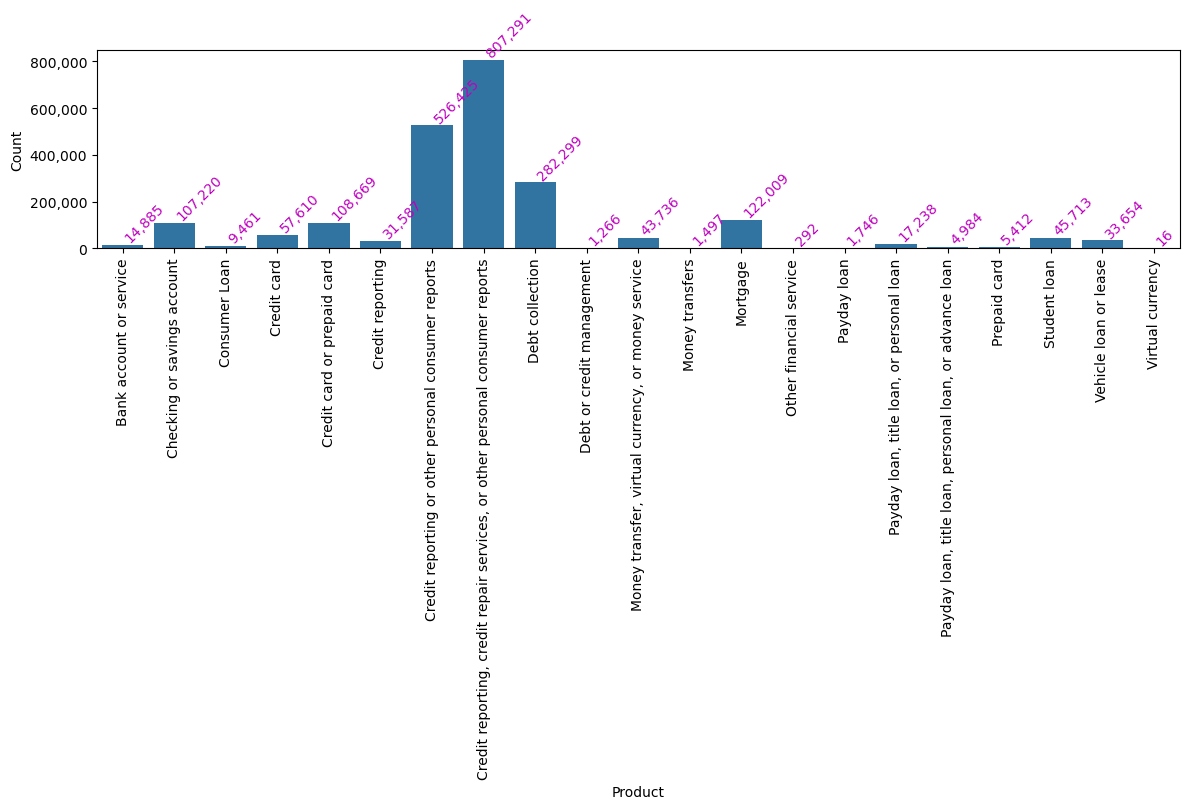

In [17]:
plt.figure(figsize=(12,8))
# plot barh chart with index as x values
# ax = sns.barplot(products_count_df['product'], products_count_df['complaint'])
ax = sns.barplot(x='product', y='complaint', data=products_count_df)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Product", ylabel='Count')
ax.set_xticklabels(products_count_df['product'])
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(products_count_df["complaint"]):        
    ax.text(i, v, "{:,}".format(v), color='m', va='bottom', rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#df['complaint'] = df['complaint'].apply(clean_up) limpieza de los datos.Su tiempo de procesamiento tarda considerablemente
#df.to_csv("data/modified/output_consumer_complaints.csv", index=False) Se almacena

In [21]:
input_df = pd.read_csv(r'E:\python\2024\pyspark\output_consumer_complaints.csv', 
                       converters={"complaint": literal_eval}) #to fetch date as a list
input_df.head()

print("Eliminar filas que quedaron sin palabras despues del limpiado, las cuales contienen listas vacias:")
print("Totales: ", input_df.shape)
input_df = input_df[input_df.astype(str)['complaint'] != '[]']
print("Despues de la eliminación: ", input_df.shape)
# xxx registros fueron eliminados.
bow_input_df = input_df

Eliminar filas que quedaron sin palabras despues del limpiado, las cuales contienen listas vacias:
Totales:  (2223010, 2)
Despues de la eliminación:  (2222669, 2)


In [22]:
# Creating a Word2Vec model using training set word2vec
vocabulary_of_all_words = input_df['complaint'].tolist()
num_features = 300
min_word_count = 10                      
num_workers = 8
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsampling for frequent words
word2vec_model_name = "300features_10minwords_10context"
word2vec_complaints = word2vec.Word2Vec(vocabulary_of_all_words, workers=num_workers, vector_size=num_features, 
                                   min_count=min_word_count, window=context, sample=downsampling)
word2vec_complaints.save(word2vec_model_name)

word2vec_complaints = gensim.models.Word2Vec.load(word2vec_model_name)

vocab_lst_flat = [item for sublist in vocabulary_of_all_words for item in sublist]
vocab_lst_flat = list(set(vocab_lst_flat))

# Exploring this model to see how well it has trained and checking for spelling mistakes in user-complaints
try:
    word2vec_complaints.wv.most_similar("good")
except KeyError:
    print("Sorry, this word doesn't exist in the vocabulary.")
    
words_not_present = 0
words_present = 0
total_unique_tokens = len(set(vocab_lst_flat))
missing_words = []

for i in vocab_lst_flat:
    try:
        p = word2vec_complaints.wv[i]  # Usa .wv para acceder al vector de la palabra
        words_present += 1
    except KeyError:
        missing_words.append(i)
        words_not_present += 1

print(words_present, words_not_present, total_unique_tokens)

29091 167685 196776


In [23]:
# Examples of spelling mistakes, grammatical errors, etc.
print(missing_words[:20])


embeddings_df = input_df['complaint'].apply(lambda complaint: get_average_word2vec(complaint, word2vec_complaints, 
                                                                                   num_features)).to_frame()
col_lst = []
for i in range(num_features):
    col_lst.append('vec_'+str(i+1))
# Easy to write to file and process when exploded into columns
exploded_em_df = pd.DataFrame(embeddings_df.complaint.tolist(), columns=col_lst)
exploded_em_df = pd.DataFrame(embeddings_df)['complaint'].apply(pd.Series)
exploded_em_df.head()
exploded_em_df.to_csv("vocab_trained_word2Vec.csv", index=False)

input_df = input_df.reset_index(drop=True)
vectorized_df = pd.concat([exploded_em_df, input_df[['product']]], axis=1)

['gonback', 'papershuffling', 'racetrac', 'allocsted', 'dodgey', 'ersed', 'synchronyfinancial', 'scratching', 'manipulater', 'servicecharges', 'assiantance', 'mnumber', 'atemping', 'alaraming', 'appertain', 'requestingthey', 'utliization', 'solidus', 'nieghbor', 'amclosing']


AttributeError: The index2word attribute has been replaced by index_to_key since Gensim 4.0.0.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4